<a href="https://colab.research.google.com/github/drsmohsin/CCSP-Buffalo/blob/main/CCSP_2_CCS_Predictions_in_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src=https://user-images.githubusercontent.com/22593272/183507755-02baef2f-ab3e-4b2d-a180-694e9cf0043d.png></center>

## Introduction
CCSP 2.0 is a Python tool that allows users to produce their own machine learning algorithms for the prediction of collision cross sections. A user only needs appropriate training and test sets, and they can generate predictions for their target compounds. These user-produced models may afford better prediction accuracy for structurally homogenous data sets than other premade algorithms (i.e., CCSbase, AllCCS, DeepCCS). Additionally, CCSP 2.0 can produce models for ion types not yet common in premade tools, assuming the user has collected an appropriate training set. 

This notebook is designed for Python beginners. There are embedded instructions explaining many of the steps, but the coding logic is only briefly described here.

For more information on the tool and sample datasets, please refer to "CCS Predictor 2.0: An Open-Source Jupyter Notebook Tool for Filtering Out False Positives in Metabolomics" (https://doi.org/10.1101/2022.08.09.503345).

## Package Management and Defining Required Functions

Before we can perform our calculations, we need to initialize the notebook.

First, we will prepare all of the Python libraries required for our notebook; these are just collections of prewritten code that we can use to simplify our work. Since Google Colabatory preloads our notebook with many of the required libraries, we can directly import them. A few specialized libraries--pubchempy, mordred, rdkit and xlsxwriter--will need to be downloaded specifically. 

Next, we will need to define a few functions, which are snippets of code that perform specific operations. We will call on these functions later in the notebook. If you are inexperienced with Python, you do not need to fully understand how they work. For more experienced users (or for anyone curious), each function has a description of its goals, inputs and outputs. For advanced users, these functions can be modified to customize the prediciton process. Note that they are collapsed by default to save space--click on the arrow by the definition statement to see the full function.

When you are ready to begin, press the play symbol on the coding cell below, then scroll to the white output box. A green checkmark will appear by the play button once the cell is finished, which usually takes less than one minute. The final output will say "NOTEBOOK READY", indicating that you can move on to the next section.

## Support Vector Regression (SVR) Modelling and CCS Prediction

Now that the notebook is ready, it's time for us to make our CCS predictions. 

This coding cell will involve a few steps:


1.   **DATA PREPARATION**: This section will allow us to select our input files, then make sure there are no typos in our molecular representations. It will also convert our 2D molecular structure representations into matrices of molecular descriptors. Once all of the X and y matrices are prepared, we can use them to build models.

2.   **MODEL TRAINING**: To build our regression model, we will first scale our training data. Then we will optimize a linear support vector regression (SVR) model using a grid search approach. This section attempts to build the best model to predict the training CCS values using all 1613 molecular descriptors. We can estimate how well this model works by using k-fold cross validation (5-fold, by default).

3.   **MODEL SIMPLIFICATION**: For more structurally similar data sets, it may be advantagous to select only a subset of the molecular descriptors. This is because having excess molecular descriptors can make it difficult for the algorithm to fit true relationships. To determine if that's the case for your data, we will attempt to simplify our model using recursive feature elimination. Generally speaking, this process iteratively removes the least important descriptors from the original model until the performance of the model (e.g. its accuracy) suffers. The idea is that if the model works just as well without those descriptors, then our model didn't need them! We will repeat the cross validation on this model to allow for easy comparison.

4.   **MODEL VALIDATION**: Because cross validation tests a model's ability to predict the data that was used to build the model, it can sometimes be overly optimistic. As an extra layer of evaluation, we will see how well the models work when predicting CCS values for compounds that are brand new. This section of code will display graphs with the calibration, cross validation and external validation results for both the full 1613 molecular descriptor model and the simplified model with less descriptors.


For additional information on any of these steps, please refer to "CCS Predictor 2.0: An Open-Source Jupyter Notebook Tool for Filtering Out False Positives in Metabolomics" (https://doi.org/10.1101/2022.08.09.503345).

---



The entire prediction process is automated for you. The only user input required is the selection of the input files. You must select two or three files during this process. Ultimately, we need three groups--training data, testing data, and target data. The training data will be used to build models, the testing data will be used for external validation, and the target molecules are those we do not know the CCS values for already. In some cases, users will have their training and testing data split already, so they will import three files (training, testing, and target). Most users, however, won't have the training and testing data pre-split. In that case, you import only two files (train/test and target), and the algorithm will ask you how much of the data to allocate to training versus testing. 

Note that each file must be in an Excel (.xlsx) format, with the training and testing (or train/test) files having three columns:


*   'Compound Name': Chemical names or labels.
*   'Input': Chemical identifiers as InChI, CID, or isomeric SMILES.
*   'CCS': Experimental CCS values.

The target data needs only two columns:

*   'Compound Name': Chemical names or labels.
*   'Input': Chemical identifiers as InChI, CID, or isomeric SMILES.


A graphical summary of this process is shown below.






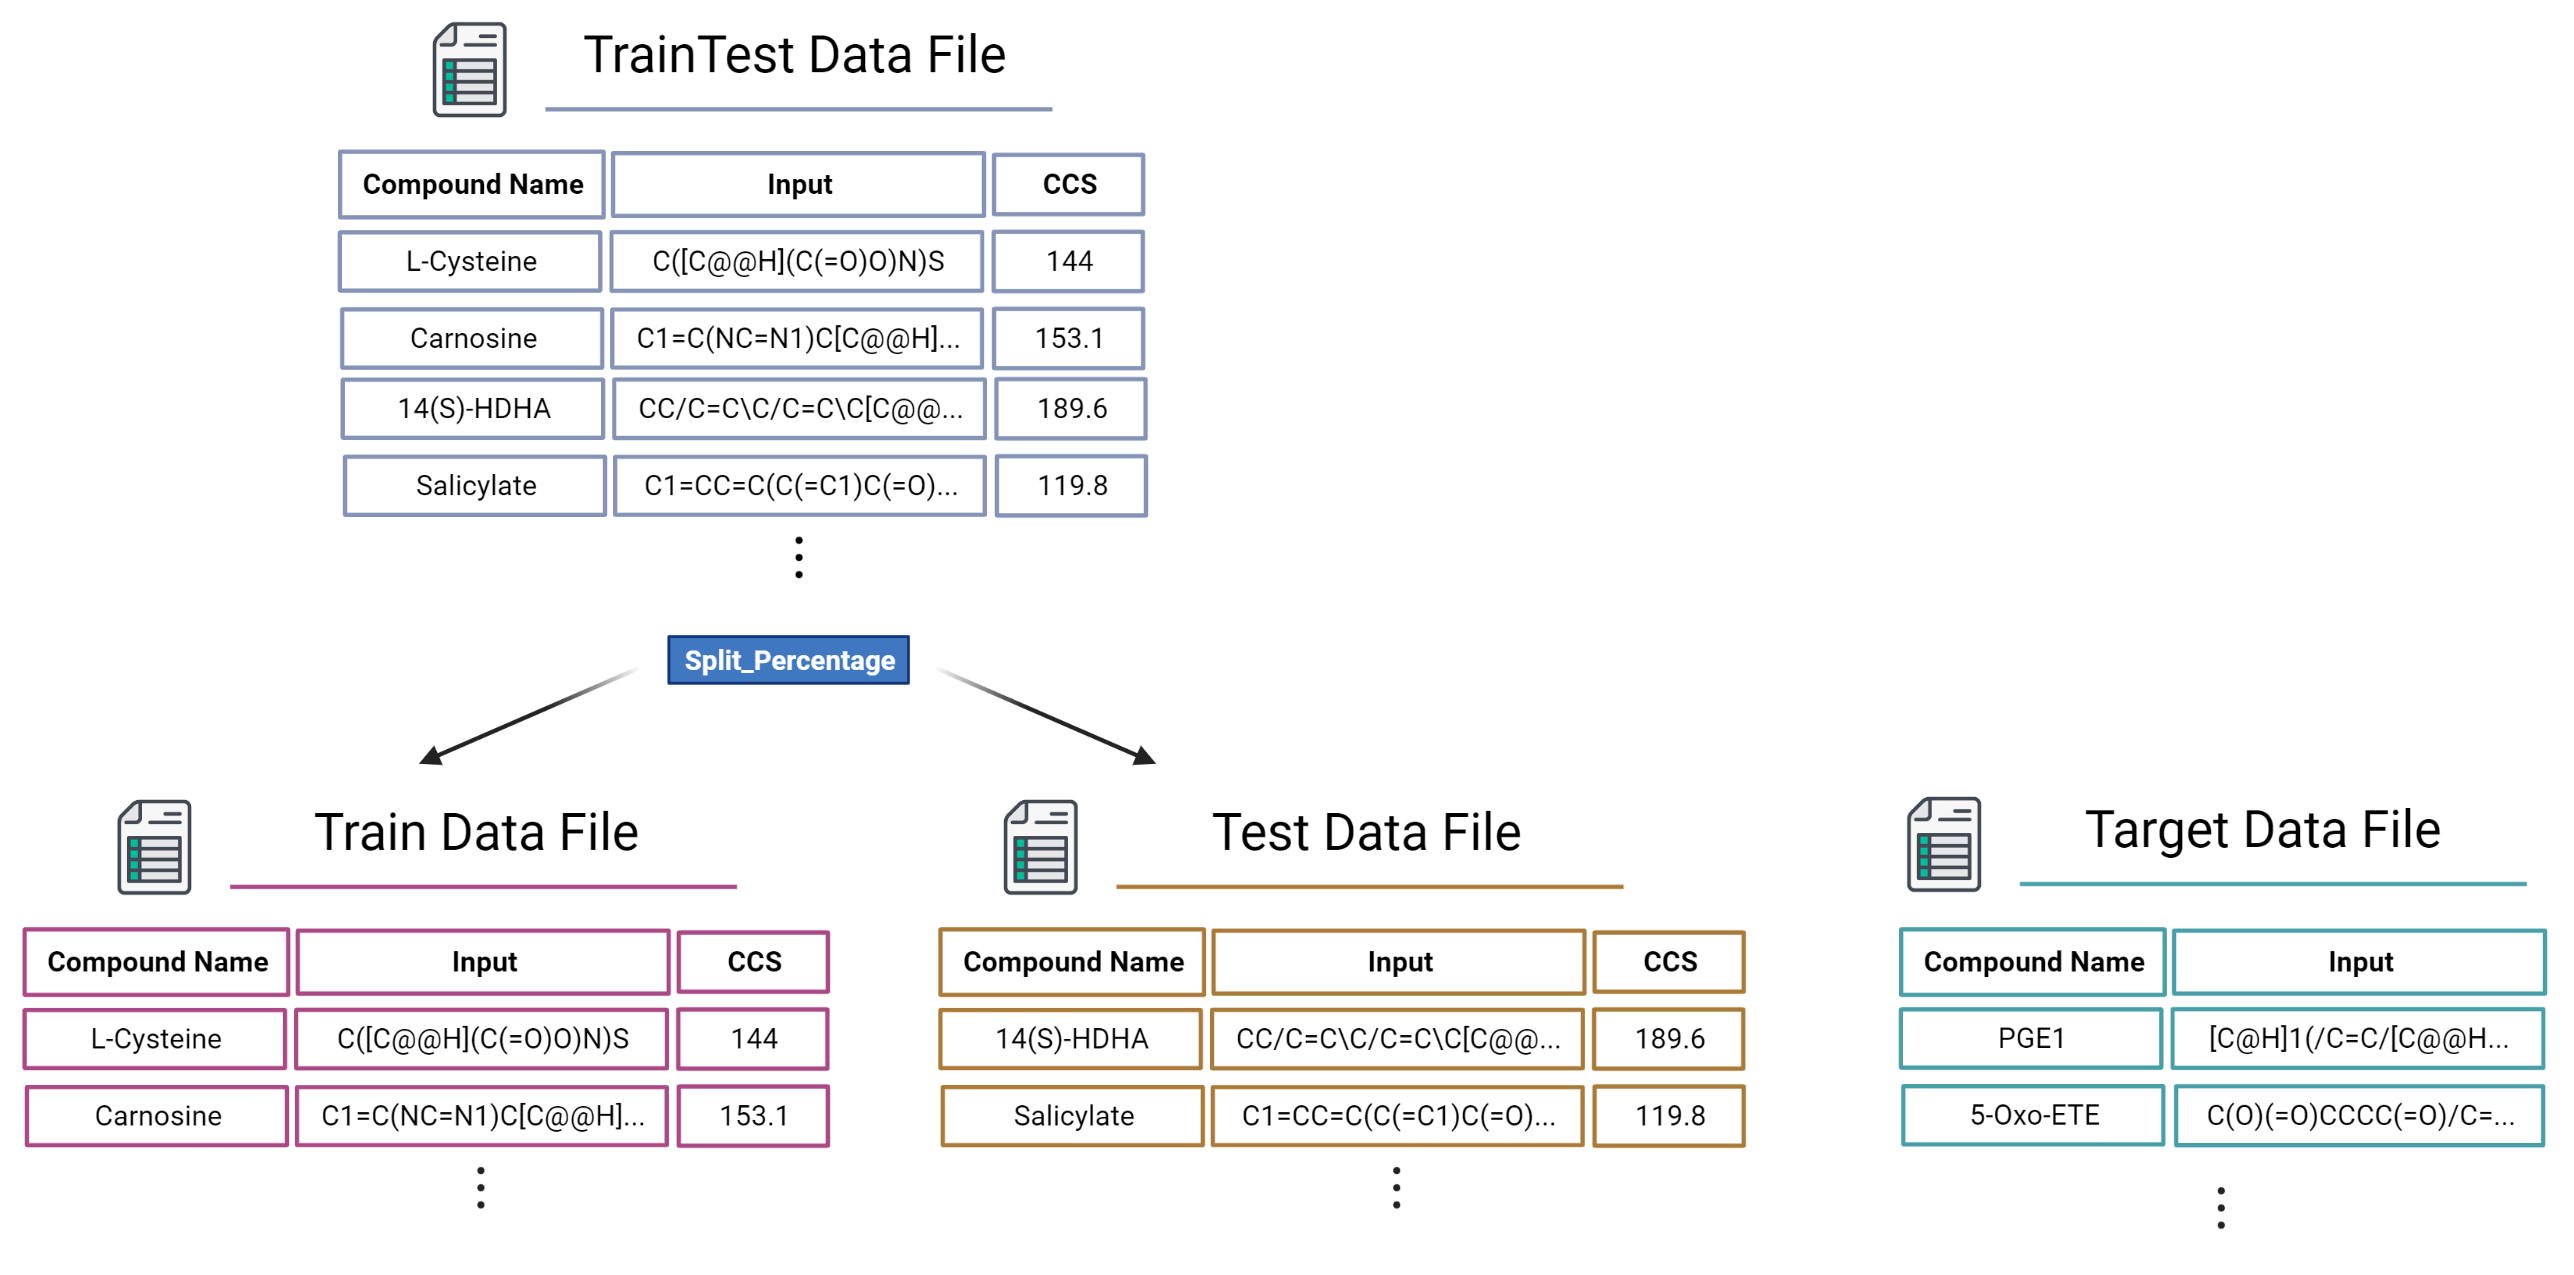


The cell below is interactive. After pressing the play button, the output box will display a series of questions to allow you to select your files. You must respond to all prompts before the code can continue. Note that if you accidently include an invalid input, the program will terminate and flag the invalid input(s). 

The rest of the prediction process requires no user input and should take less than 10 minutes to complete. Remember that this section of the code is complete only after the green checkmark appears!

In [ ]:
%%time
print("Downloading non-standard packages.")
!pip install pubchempy mordred rdkit xlsxwriter
print("Non-standard packages downloaded.")
print("Importing standard packages.")
# Import packages block

from google.colab import files
from IPython.utils import io
import math
import matplotlib.pyplot as plt
from multiprocessing import freeze_support
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pubchempy as pcp
import sklearn
from mordred import Calculator, descriptors
from rdkit import Chem
import shutil
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedShuffleSplit,
    cross_val_predict,
    cross_validate
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.utils import shuffle
import statistics
import sys
from sys import stdout
import time

print("Standard packages downloaded.")
print("Defining required functions.")

def select_input_files():
    """
    Creates a series of prompts to select Excel notebooks for training, testing and target molecules; can randomly divide a data set if the training and testing molecules are not pre-split by user.
    
    Input Parameters:
        None
    
    Intermediate Parameters: 
        TestTrain file (Excel workbook): Excel workbook with molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Target file (Excel workbook): Excel workbook with molecule names and identifiers (CID, InChI or SMILES).
        split_percentage (float): a number between 0 or 100.
        
        or
        
        Train file (Excel workbook): Excel workbook with molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Test file (Excel workbook): Excel workbook with molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Target file (Excel workbook): Excel workbook with molecule names and identifiers (CID, InChI or SMILES).
       
        
    Returns:
        Train_Book (Pandas DataFrame): Table of training molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Test_Book (Pandas DataFrame): Table of test molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Target_Book (Pandas DataFrame): Table of target molecule names and identifiers (CID, InChI or SMILES).
    
    """

    # To avoid an error where users cannot resubmit files with the same file names (i.e., after fixing a typo), the content folder is erased/reset here.

    folder = '/content/'
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

    i = 0

    while i < 3:
        answer = input("Is your data set already split into separate training and test sets? (YES/NO): ")
        if any(answer.lower() == f for f in ["yes", 'y', '1', 'ye']):
            print("You have indicated that your data is already split, so we will upload three files: (1) training data, (2) testing data, and (3) target data.")

            print("\n")
            print("Select the Excel workbook with your training data. Make sure you have the three following columns: \n \n 'Compound Name': Chemical names or labels. \n \n 'Input': Chemical identifiers as InChI, CID, or isomeric SMILES. \n \n 'CCS': Experimental CCS values.")
            print("\n")

            train_uploaded = files.upload()
            for training_file_name in train_uploaded.keys():
              print('User uploaded file "{name}" with length {length} bytes'.format(
                  name=training_file_name, length=len(train_uploaded[training_file_name])))
              
            Train_Book = pd.read_excel(training_file_name)

            print("\n")
            print("Select the Excel workbook with your test data. Make sure you have the three following columns: \n \n 'Compound Name': Chemical names or labels. \n \n 'Input': Chemical identifiers as InChI, CID, or isomeric SMILES. \n \n 'CCS': Experimental CCS values.")
            print("\n")

            test_uploaded = files.upload()
            for testing_file_name in test_uploaded.keys():
              print('User uploaded file "{name}" with length {length} bytes'.format(
                  name=testing_file_name, length=len(test_uploaded[testing_file_name])))
            
            Test_Book = pd.read_excel(testing_file_name)

            print("\n")
            print("Select the Excel workbook with your target compounds. Make sure you have the two following columns: \n \n 'Compound Name': Chemical names or labels. \n \n 'Input': Chemical identifiers as InChI, CID, or isomeric SMILES.")
            print("\n")

            target_uploaded = files.upload()
            for target_file_name in target_uploaded.keys():
              print('User uploaded file "{name}" with length {length} bytes'.format(
                  name=target_file_name, length=len(target_uploaded[target_file_name])))              

            Target_Book = pd.read_excel(target_file_name)

            break

        elif any(answer.lower() == f for f in ['no', 'n', '0']):
            print("You have indicated that your data is NOT already split, so we will upload two files: (1) the combined training and testing data and (2) target data.")

            print("\n")
            print("Select the Excel workbook with your combined training and test data, and the data will be randomly split for you. Make sure you have the three following columns: \n \n 'Compound Name': Chemical names or labels.  \n \n 'Input': Chemical identifiers as InChI, CID, or isomeric SMILES.  \n \n 'CCS': Experimental CCS values.")
            print("\n")

            traintest_uploaded = files.upload()
            for traintest_file_name in traintest_uploaded.keys():
              print('User uploaded file "{name}" with length {length} bytes'.format(
                  name=traintest_file_name, length=len(traintest_uploaded[traintest_file_name])))
            
            TrainTest_Book =  pd.read_excel(traintest_file_name)
            print("\n")

            w = 0
            while w < 3:
                split_percentage = input("What percentage of the input molecules would you like to allocate towards training? [Between 0 and 100]:  ")
                try:
                    split_percentage = int(split_percentage)
                    if 0 < split_percentage < 100:
                      Rand_Master = TrainTest_Book.reindex(np.random.permutation(TrainTest_Book.index))
                      Train_Book = Rand_Master.sample(frac = split_percentage/100)
                      Test_Book = pd.concat([TrainTest_Book, Train_Book]).drop_duplicates(keep=False)
                      break
                except ValueError:
                    w += 1
                    if w < 3:
                        print('The value you entered is not a valid integer value. Please enter a split percentage in the range: 0-100')
                    else:
                        print("More three input errors have been detected. Please reread the prompt and try again.")
                        sys.exit()

            print("\n")
            print("Select the Excel workbook with your target compounds. Make sure you have the two following columns: \n \n 'Compound Name': Chemical names or labels. \n \n 'Input': Chemical identifiers as InChI, CID, or isomeric SMILES.")
            print("\n")
            target_uploaded = files.upload()
            for target_file_name in target_uploaded.keys():
              print('User uploaded file "{name}" with length {length} bytes'.format(
                  name=target_file_name, length=len(target_uploaded[target_file_name])))

            Target_Book = pd.read_excel(target_file_name)

            break
        else:
            i += 1
            if i < 3:
                print('Please enter "yes" or "no".')
            else:
                print("More three input errors have been detected. Please reread the prompt and try again.")
                
    return Train_Book, Test_Book, Target_Book

def check_inputs(Book, column_title='Input'):
    """
    Determines input identifier type (CID, InChI or SMILES) and checks for any invalid inputs.
    
    Parameters:
        Book (Pandas DataFrame): Table with a column containing input identifiers (CID, InChI or SMILES).
        column_title (string): The title of the column containing input identifiers; 'Input' by default.
        
    Returns:
        input_type (string): Type of input identifiers used ("CID", "InChI" or "SMILES").
        input_errors (list): List of identifiers that are invalid.
    
    """
    input_errors = []
    if isinstance(list(Book[column_title])[0], int)==True:
        print("   Input type CID assumed.")
        input_type = 'CID'
        for i in Book[column_title]:
            if isinstance(i, int)!=True:
                input_errors.append(i)
    elif 'InChI' in list(Book[column_title])[0]:
        print("   Input type InChI assumed.")
        input_type = 'InChI'
        for i in Book[column_title]:
            if Chem.MolFromInchi(i) is None:
                input_errors.append(i)
    else:
        print("   Input type SMILES assumed.")
        input_type = "SMILES"
        for i in Book[column_title]:
            if Chem.MolFromSmiles(i) is None:
                input_errors.append(i)
                
    return input_type, input_errors

def get_compounds_from_cid(input_list):
    """
    Efficiently fetches the compound files for corresponding PubChem Chemical Identifiers (CID).
    
    Parameters:
        input_list (Pandas Series): List of input identifiers in CID form.
        
    Returns:
        reconstructed_compounds (list): List of compound for each input molecule identifier provided.
        
    Logic:
        PubChem limits the number of requests that can be processed by a single user within a specified timeframe AND limits the time that can be allocated to a single request (https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest).
        This code fetches compound files as dictionaries in batches of 100.
    """
    CID_list = [int(i) for i in input_list]
    reconstructed_cids = []
    reconstructed_compounds = []
    comp_val = 0
    initial_val = 0
    while comp_val < len(CID_list):
        initial_val = comp_val
        comp_val = comp_val + 100
        #print(comp_val)
        #print(CID_list[initial_val:comp_val])
        reconstructed_cids.extend(CID_list[initial_val:comp_val])
        compounds_vals = pcp.get_compounds(CID_list[initial_val:comp_val], 'cid')
        reconstructed_compounds.extend(compounds_vals)
        progress = 100*(initial_val)/len(CID_list)
        # Trick to update status on the same line
        if comp_val > len(CID_list):
            progress = 100
        stdout.write("\r        %d%% of compound files retrieved from PubChem." % progress)
        stdout.flush()
    stdout.write("\n")
    if reconstructed_cids!=CID_list:
            print("WARNING: At least one Compound Identifier (CID) was not converted into a PubChem compound file correctly.")
    return reconstructed_compounds

def calculate_descriptors(input_list, input_type='InChI'):
    """
    Calculates Mordred molecular descriptors from input identifiers (CID, InChI or SMILES).
    
    Parameters:
        input_list (Pandas Series): List of input identifiers (CID, InChI or SMILES) of the same type.
        input_type (string): The type of input identifiers; 'InChI' by default.
        
    Returns:
        descriptor_list (Mordred DataFrame): Table of molecular descriptors for each input molecule identifier provided.
    
    """
    if input_type=='InChI':
        mol_list = [Chem.MolFromInchi(i) for i in input_list]
    if input_type=='SMILES':
        mol_list = [Chem.MolFromSmiles(i) for i in input_list]
    if input_type=='CID':
        compounds_list = get_compounds_from_cid(input_list)
        mol_list = [Chem.MolFromSmiles(i.isomeric_smiles) for i in compounds_list]
    calc = Calculator(descriptors, ignore_3D=True)
    with io.capture_output() as captured:
        descriptor_list = calc.pandas(mol_list)
    return descriptor_list

def variable_assigner(Train_Book, Test_Book, Target_Book, column_title='Input', train_input_type="InChI", test_input_type="InChI", target_input_type="InChI"):
    """
    Constructs input matrices for model development.
    
    Parameters:
        Train_Book (Pandas DataFrame): Table of training molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Test_Book (Pandas DataFrame): Table of test molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Target_Book (Pandas DataFrame): Table of target molecule names and identifiers (CID, InChI or SMILES).
        column_title (string): The title of the column containing input identifiers; 'Input' by default.
        train_input_type (string): Type of input identifiers used ("CID", "InChI" or "SMILES"); "InChI" by default.
        test_input_type (string): Type of input identifiers used ("CID", "InChI" or "SMILES"); "InChI" by default.
        target_input_type (string): Type of input identifiers used ("CID", "InChI" or "SMILES"); "InChI" by default.
        
    Returns:
        X_train (Mordred DataFrame): Table of molecular descriptors for each input molecule identifier provided.
        y_train (list): List of experimental CCS values.
        X_test (Mordred DataFrame): Table of molecular descriptors for each input molecule identifier provided.
        y_test (list): List of experimental CCS values.
        X_target (Mordred DataFrame): Table of molecular descriptors for each input molecule identifier provided.
    
    """
    print("Preparing descriptor matrices from input lists...")
    print("     Calculating X_train descriptors...")
    X_train = calculate_descriptors(Train_Book[column_title], train_input_type)
    print("     Calculating X_test descriptors...")
    X_test = calculate_descriptors(Test_Book[column_title], test_input_type)
    print("     Calculating X_target descriptors...")
    X_target = calculate_descriptors(Target_Book[column_title], target_input_type)
    print("All descriptor matrices completed. \n")
    print("Assigning CCS lists to y_train and y_test matrices...")
    y_train = list(Train_Book['CCS'])
    y_test = list(Test_Book['CCS'])
    print("Y matrices prepared. \n")
    return X_train, y_train, X_test, y_test, X_target

def clean_up_descriptors(input_frame):
    """
    Removes non-numerical molecular descriptors from a matrix.
    
    Parameters:
        input_frame (Mordred DataFrame): Table of molecular descriptors.
        
    Returns:
        output_frame (Mordred DataFrame): Table of molecular descriptors after removing non-numerical descriptors.
    
    """
    start_length = len(input_frame.columns)
    output_frame = input_frame.copy().select_dtypes(['number'])
    end_length = len(output_frame.columns)
    print("          Number of inapplicable descriptors: ", start_length-end_length, "\n")
    return output_frame

def drop_constant_column(input_frame):
    """ 
    Removes the columns of a Mordred dataframe that are constant for all rows.
        
    Parameters:
        input_frame (Mordred DataFrame): Table of molecular descriptors.
        
    Returns:
        output_frame (Mordred DataFrame): Table of molecular descriptors after removing constant descriptors.
    """
    start_len = len(input_frame)
    output_frame = input_frame.loc[:, (input_frame != input_frame.iloc[0]).any()]
    end_len = len(output_frame)
    print("          Number of constant descriptors removed: ", start_len-end_len, "\n")
    return output_frame

def removeoutlier(input_frame1, input_frame2, threshold):
    """ 
    Removes molecular descriptor columns from a Mordred dataframe if they contain outlier values when compared to the corresponding column in a reference Mordred dataframe.
        
    Parameters:
        input_frame1 (Mordred DataFrame): Table of molecular descriptors to be inspected.
        input_frame2 (Mordred DataFrame): Table of molecular descriptors to serve as a reference.
        threshold (float): The z-score required for a value to be considered an outlier [(val-mean)/std dev].
        
    Returns:
        output_frame1 (Mordred DataFrame): Table of molecular descriptors after removing columns with outling descriptors.
        output_frame2 (Mordred DataFrame): Table of molecular descriptors after removing columns with outling descriptors.
        
    """
    input_frame1_temporary = input_frame1.copy()
    input_frame2_temporary = input_frame2.copy()
    removed_count = 0
    for i in input_frame2.columns:
        if max(input_frame1[i]) > statistics.mean(input_frame2[i])+threshold*statistics.stdev(input_frame2[i]) or min(input_frame1[i]) < statistics.mean(input_frame2[i])-threshold*statistics.stdev(input_frame2[i]):
            input_frame1_temporary.drop(columns = i)
            input_frame2_temporary.drop(columns = i)
            removed_count = removed_count+1
    output_frame1 = input_frame1_temporary
    output_frame2 = input_frame2_temporary
    print("     Number of descriptors dropped due to outlier function: ", removed_count, "\n")
    return output_frame1, output_frame2

def svr_model_linear(X_train, y_train, C_list = [2**(i) for i in range(-8,-1)], epsilon_list = [0.5, 1, 5]):
    """ 
    Constructs a linear support vector regression model with hyperparameter optimization.
        
    Parameters:
        X_train (Mordred DataFrame): Table of molecular descriptors.
        y_train (list): List of experimental CCS values.
        C_list (list of floats) = GridSearch options for cost hyperparameter; deflaut is [2**(i) for i in range(-8,-1)].
        epsilon_list (list of floats) = GridSearch options for epsilon hyperparameter; deflaut is [0.5, 1, 5].
        
    Returns:
        best_svr (sklearn.svm._classes.SVR object): The optimium SVR model with hyperparameters and weights selected through cross-validation.
        scores (dictionary): The results of the GridSearchCV trials for each C and epsilon pair.
        grid_result (sklearn.model_selection._search.GridSearchCV object): The GridSearchCV object that contains the parameters used to set up the hyperparameter optimization.
        y_train_cross_validation (numpy.ndarray object): The predicted CCS values of the training molecules following k-fold cross-validation.
        
    """
    print("     Performing grid search hyperparamter optimization...")
    gsc = GridSearchCV(
        estimator=SVR(kernel='linear'),
        param_grid={'C':  C_list, 'epsilon': epsilon_list,},
        cv=5, scoring='neg_root_mean_squared_error', verbose=False, n_jobs=-1)
    grid_result = gsc.fit(X_train, y_train)
    print("     Grid search completed.\n")
    best_params = grid_result.best_params_
    print("     Fitting SVR model...")
    best_svr = SVR(kernel='linear', C=best_params["C"], epsilon=best_params["epsilon"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=500, verbose=False, max_iter=-1)
    print("     SVR model constructed.\n")
    print("     Performing k-fold cross-validation...")
    scoring = {'abs_error': 'neg_mean_absolute_error','squared_error': 'neg_mean_squared_error'}
    scores = cross_validate(best_svr, X_train, y_train, cv=5, scoring=scoring, return_train_score=True, n_jobs=-1)
    y_train_cross_validation = cross_val_predict(best_svr, X_train, y_train, cv=5, n_jobs=-1, verbose=False)
    print("     Cross-validation completed.\n")
    return best_svr, scores, grid_result, y_train_cross_validation

def initial_ccs_prediction(X_train, y_train, X_test, y_test, X_target, remove_outlier=False, threshold=1000):
    """
    Subscribed (“external”) function that uses previously described nested ("internal") functions to predict CCS values with a linear SVR model.

    Parameters:
        X_train (Mordred DataFrame): Table of molecular descriptors for the training molecules.
        y_train (list): List of experimental CCS values for the training molecules.
        X_test (Mordred DataFrame): Table of molecular descriptors for the test molecules.
        y_test (list): List of experimental CCS values for the test molecules.
        X_target (Mordred DataFrame): Table of molecular descriptors for the target molecules.
        remove_outlier (boolean): Determines whether to apply the removeoutlier function; default is False.
        threshold (float): The z-score required for a value to be considered an outlier [(val-mean)/std dev]; default is 1000 when remove_outlier is True.

    Nested functions:
        clean_up_descriptors
        drop_constant_column
        removeoutlier
        svr_model_linear

    Returns:
        X_train_clean (Mordred DataFrame): Table of training molecular descriptors after removing non-numerical and constant descriptors.
        X_test_clean (Mordred DataFrame): Table of test molecular descriptors after removing non-numerical and constant descriptors.
        X_target_clean (Mordred DataFrame): Table of target molecular descriptors after removing non-numerical and constant descriptors.
        X_train_scaled (numpy.ndarray object): Array of training molecular descriptors following column-wise z-transformation.
        model (sklearn.svm._classes.SVR object): The optimium SVR model with hyperparameters and weights selected through cross-validation.
        grid_results (sklearn.model_selection._search.GridSearchCV object): The GridSearchCV object that contains the parameters used to set up the hyperparameter optimization.
        y_train_predicted (numpy.ndarray object): The predicted CCS values of training molecules using the SVR model.
        y_train_cross_validation (numpy.ndarray object): The predicted CCS values of training molecules following k-fold cross-validation.
        y_test_predicted (numpy.ndarray object): The predicted CCS values of test molecules using the SVR model.
        y_target_predicted (numpy.ndarray object): The predicted CCS values of target molecules using the SVR model.
     
    """
    print("Checking for constant and inapplicable descriptors... \n")
    print("     Investigating X_train matrix for inapplicable descriptors...")
    X_train_clean = clean_up_descriptors(X_train)
    print("     Investigating X_train matrix for constant descriptors...")
    X_train_clean = drop_constant_column(X_train_clean)
    print("     Investigating X_test matrix for inapplicable descriptors...")
    X_test_clean = clean_up_descriptors(X_test)
    print("     Investigating X_target matrix for inapplicable descriptors...")
    X_target_clean = clean_up_descriptors(X_target)
    common_columns = [col for col in set(X_train_clean.columns).intersection(X_test_clean.columns).intersection(X_target_clean.columns)]
    print("Constant and inapplicable descriptors successfully filtered. \n")
    X_train_clean, X_test_clean, X_target_clean = X_train_clean[common_columns], X_test_clean[common_columns], X_target_clean[common_columns]
    if remove_outlier==True:
        print("Investigating X_test for descriptors with significant outliers...")
        X_test_clean, X_train_clean = removeoutlier(X_test_clean, X_train_clean, threshold)
        print("Investigating X_target for descriptors with significant outliers...")
        X_target_clean, X_train_clean = removeoutlier(X_target_clean, X_train_clean, threshold)
    common_columns = [col for col in set(X_train_clean.columns).intersection(X_test_clean.columns).intersection(X_target_clean.columns)]
    X_train_clean, X_test_clean, X_target_clean = X_train_clean[common_columns], X_test_clean[common_columns], X_target_clean[common_columns] 
    print("Scaling descriptor matrices...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_test_scaled = scaler.transform(X_test_clean)
    X_target_scaled = scaler.transform(X_target_clean)
    print("Descriptor matrices scaled. \n")
    print("Building an SVR model using all applicable Mordred descriptors... \n")
    model, scores, grid_results, y_train_cross_validation = svr_model_linear(X_train_scaled, y_train)
    print("Model completed.\n")
    print("Predicting CCS values...")
    model.fit(X_train_scaled, y_train)
    y_train_predicted = model.predict(X_train_scaled)
    y_test_predicted = model.predict(X_test_scaled)
    y_target_predicted = model.predict(X_target_scaled)
    print("All predictions completed.\n")
    return X_train_clean, X_test_clean, X_target_clean, X_train_scaled, model, grid_results, y_train_predicted, y_train_cross_validation, y_test_predicted, y_target_predicted
    
def regression_metrics(true_values, predicted_values):
    """ 
    Calculates root mean squared error (RMSE), median relative error (MRE), and goodness of fit (R^2)/goodness of prediction (Q^2) from a set of predicted values and a corresponding set of true values.
        
    Parameters:
        true_values (numpy.ndarray object or list): Ground truth (correct) values.
        predicted_values (numpy.ndarray object or list): Estimated values.
        
    Returns:
        RMSE (float): Root mean squared error between true and predicted values.
        MRE (float): Median relative error between true and predicted values.
        R2 (float): Goodness of fit (R^2) [if prediction is from a single model]/goodness of prediction (Q^2) [if predictions are from cross-validation] between true and predicted values.
    """
    
    RMSE = mean_squared_error(true_values, predicted_values, squared=False)
    MRE = statistics.median([abs(true_values[i]-predicted_values[i])/true_values[i]*100 for i in range(len(predicted_values))])
    R2 = r2_score(true_values, predicted_values)
    return RMSE, MRE, R2

def prediction_plot(true_values, predicted_values, input_book, hover_column=["Compound Name"], title_string = None):
    """ 
    Plots ground truth (correct) values against predicted values.
        
    Parameters:
        true_values (numpy.ndarray object or list): Ground truth (correct) values.
        predicted_values (numpy.ndarray object or list): Estimated values.
        input_book (Pandas DataFrame): Table assigning molecule names to corresponding molecular identifiers and experimental CCS values.
        hover_column (list(string)): Name of column(s) in input_book with desired information to appear when hovering over a data point; ["Compound Name"] by default.
        title_string (string): Title of plot to be displayed; default is None.
        
    Returns:
        prediction_plot (plotly.graph_objs._figure.Figure): Plotly plot object.
        
    """
        
    input_book["Relative Error (%)"] = [round(abs(true_values[i]-predicted_values[i])/true_values[i]*100,2) for i in range(len(true_values))]
    prediction_plot = px.scatter(input_book, 
                               x=true_values, 
                               y=predicted_values,  
                               color_continuous_scale= px.colors.diverging.RdYlGn_r,
                               color = "Relative Error (%)",
                               template = 'none', 
                               hover_data=hover_column,
                               title=title_string,
                               trendline = "ols")
    prediction_plot.update_layout(autosize = False, width = 900, height = 500, hovermode="closest")
    prediction_plot.update_xaxes(title_text = "Measured CCS (<span>&#8491;</span><sup>2</sup>)", title_font = {"size": 15}, title_standoff = 25)
    prediction_plot.update_yaxes(title_text = "Predicted CCS (<span>&#8491;</span><sup>2</sup>)", title_font = {"size": 15}, title_standoff = 25)
    prediction_plot.update_layout(hoverlabel_align = 'auto')
    prediction_plot.data[1].line.color = 'skyblue'
    prediction_plot.add_shape(type="line", x0=min(min(true_values),min(predicted_values)), 
                            x1=max(max(true_values),max(predicted_values)), 
                            y0=min(min(true_values),min(predicted_values)), 
                            y1=max(max(true_values),max(predicted_values)),
                            line = dict(dash = 'dash'))
    prediction_plot.show()
    return prediction_plot

def model_diagnostics_plot(X_block, model_name):
    """ 
    Plots the feature weights for each feature (variable) in an SVR model.
        
    Parameters:
        X_block (Mordred DataFrame): Table of molecular descriptors for the training molecules.
        model_name (sklearn.svm._classes.SVR object): The optimium SVR model with hyperparameters and weights selected through cross-validation.
        
    Returns:
        model_diagnostic_plot (plotly.graph_objs._figure.Figure): Plotly plot object.
        
    """
    df_name = pd.DataFrame()
    df_name['Descriptor'] = list(X_block.columns)
    model_diagnostic_plot = px.scatter(df_name, x=range(len(list(model_name.coef_[0]))), y=list(model_name.coef_[0]),  color_discrete_sequence= px.colors.sequential.Turbo, color = list(model_name.coef_[0]), template = 'none', hover_data=['Descriptor'])
    model_diagnostic_plot.update_yaxes(title_text = "Feature Weight", title_font = {"size": 15}, title_standoff = 25)
    model_diagnostic_plot.update_xaxes(title_text = "Descriptor Number", title_font = {"size": 15}, title_standoff = 25)
    model_diagnostic_plot.show()
    return model_diagnostic_plot
    
def rfe_variable_selection(X_train_scaled, y_train, grid_results):
    """ 
    Performs variable selection via recursive feature elimination to simplify an SVR model.
    
    Parameters:
        X_train_scaled (numpy.ndarray object): Array of training molecular descriptors following column-wise z-transformation.
        grid_results (sklearn.model_selection._search.GridSearchCV object): The GridSearchCV object that contains the parameters used to set up the hyperparameter optimization.
        
    Returns:
        rfecv (sklearn.feature_selection._rfe.RFECV): Feature selection object with results of iterative feature removal.
        
    """
    estimator = SVR(C=grid_results.best_params_['C'], cache_size=500, coef0=0.1, epsilon=grid_results.best_params_['epsilon'], kernel='linear')
    rfecv = RFECV(estimator, step=5, cv=5, scoring='neg_root_mean_squared_error', min_features_to_select=1, verbose=0, n_jobs =-1)
    print("Initiating selection process...")
    rfecv.fit(X_train_scaled, y_train)
    plt.figure()
    plt.xlabel("Number of Features Selected")
    plt.ylabel("Negative Root Mean Squared Error ($\AA^2$)")
    x_points = list(range(len(X_train_clean.columns), 1, -5))

    if 1 not in x_points:
        x_points = x_points+[1]
        
    plt.plot(x_points[::-1], rfecv.cv_results_['mean_test_score'])
    plt.show()
    print("The number of features selected: ", rfecv.n_features_)
    print("Selection process completed. \n")
    return rfecv
    
def rfe_ccs_prediction(X_train_clean, y_train, X_test_clean, y_test, X_target_clean, rfecv):
    """ 
    Subscribed (“external”) function that uses previously described nested ("internal") function to predict CCS values with a linear SVR model following recursive feature elimination.
    
    Parameters:
        X_train_clean (Mordred DataFrame): Table of training molecular descriptors after removing non-numerical and constant descriptors.
        y_train (list): List of experimental CCS values for the training molecules.
        X_test_clean (Mordred DataFrame): Table of test molecular descriptors after removing non-numerical and constant descriptors.
        y_test (list): List of experimental CCS values for the test molecules.
        X_target_clean (Mordred DataFrame): Table of target molecular descriptors after removing non-numerical and constant descriptors.
        rfecv (sklearn.feature_selection._rfe.RFECV): Feature selection object with results of iterative feature removal.

    Nested functions:
        svr_model_linear
        
    Returns:
        model_rfe (sklearn.svm._classes.SVR object): The optimium SVR model with hyperparameters and weights selected through cross-validation.
        grid_result_rfe (sklearn.model_selection._search.GridSearchCV object): The GridSearchCV object that contains the parameters used to set up the hyperparameter optimization.
        X_test_rfe (Mordred DataFrame): Table of test molecular descriptors after removing non-numerical and constant descriptors.
        y_train_predicted_rfe (numpy.ndarray object): The predicted CCS values of training molecules using the SVR model.
        y_train_cross_validation_rfe (numpy.ndarray object): The predicted CCS values of training molecules following k-fold cross-validation.
        y_test_predicted_rfe (numpy.ndarray object): The predicted CCS values of test molecules using the SVR model.
        y_target_predicted_rfe (numpy.ndarray object): The predicted CCS values of target molecules using the SVR model.

    """    
    
    print("Modifying descriptor matrices to use only selected descriptors...")    
    X_rfe = X_train_clean[X_train_clean.columns[rfecv.support_]]
    X_test_rfe = X_test_clean[X_train_clean.columns[rfecv.support_]]
    X_target_rfe = X_target_clean[X_train_clean.columns[rfecv.support_]]
    print("New descriptor matrices constructed. \n")
    # Apply a z-transformation on X_train and X-Test using the mean and standard deviation of the columns in X.
    print("Scaling descriptor matrices...")
    scaler = StandardScaler()
    X_rfe_scaled = scaler.fit_transform(X_rfe)
    X_test_rfe_scaled = scaler.transform(X_test_rfe)
    X_target_rfe_scaled = scaler.transform(X_target_rfe)
    print("Descriptor matrices scaled. \n")
    print("Building an SVR model with descriptors selected with RFE... \n")
    model_rfe, scores_rfe, grid_result_rfe, y_train_cross_validation_rfe = svr_model_linear(X_rfe_scaled, y_train)
    # Determine variable weights by fitting X_train to y using selected hyperparameters.
    model_rfe.fit(X_rfe_scaled, y_train)
    print("Simplified model completed. \n")
    print("Performing CCS predictions...")
    # Using model, predict the CCS for the calibration set. Since this is predicting the CCS values of the set used to train the model, the error should be quite small.
    y_train_predicted_rfe = model_rfe.predict(X_rfe_scaled)
    y_test_predicted_rfe = model_rfe.predict(X_test_rfe_scaled)
    y_target_predicted_rfe = model_rfe.predict(X_target_rfe_scaled)
    print("All predictions completed. \n")
    return model_rfe, grid_result_rfe, X_test_rfe, y_train_predicted_rfe, y_train_cross_validation_rfe, y_test_predicted_rfe, y_target_predicted_rfe
    
def summary_plot(y_train, y_test, y_train_predicted, y_train_cross_validation, y_test_predicted, labelsize = 12, legendsize = 12, titlesize = 14, textsize = 12):
    """ 
    Plots ground (true) values against estimated values for calibration, cross-validation and (external) validation processes.
    
    Parameters:
        y_train (list): List of experimental CCS values for the training molecules.
        y_test (list): List of experimental CCS values for the test molecules.
        y_train_predicted (numpy.ndarray object): The predicted CCS values of training molecules using the SVR model.
        y_train_cross_validation (numpy.ndarray object): The predicted CCS values of training molecules following k-fold cross-validation.
        y_test_predicted (numpy.ndarray object): The predicted CCS values of test molecules using the SVR model.
        labelsize (integer): Determines size of plot labels; default is 12.
        legendsize (integer): Determines size of legend text; default is 12.
        titlesize (integer): Determines size of title text; default is 14.
        textsize (integer): Determines size of axes labels; default is 12.
        
    Returns:
        f (matplotlib.figure.Figure): Matplotlib plot object.
        
    """
    
    f,(ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,18))
    values = list(range(int(round(min(min(y_train), min(y_test), min(y_train_cross_validation), min(y_train_predicted), min(y_test_predicted)),0)),
                        int(round(max(max(y_train), max(y_test), max(y_train_cross_validation), max(y_train_predicted), max(y_test_predicted)),0))))
    RMSE, MRE, R2 = regression_metrics(y_train, y_train_predicted)
    plt.subplot(1,3,1)
    plt.text(0.05, 0.625, "Median Error = "+str(round(MRE,3))+"%" + "\n"+ "RMSE = "+str(round(RMSE,3))+" $\AA^2$"+ "\n"+"$R^2$ = "+str(round(R2,3)),
        ha='left', va='top', transform=ax1.transAxes, fontsize=textsize)
    plt.scatter( y_train, y_train_predicted, color='powderblue', marker = 'o', edgecolor='black', label="Calibration", s=50)
    m_0, b_0 = np.polyfit(y_train, y_train_predicted, 1)
    plt.plot(np.asarray(values), np.asarray(values)*m_0+b_0, color='powderblue', linestyle='-', label="Calibration Fit", linewidth = 1.4)
    plt.plot(values, np.asarray(values), color='black', linestyle='--', label="1:1", linewidth = 1)
    plt.title("Calibration Prediction", fontsize=titlesize)
    plt.ylabel('Predicted CCS ($\AA^2$)', fontsize=labelsize)
    plt.xlabel('Measured CCS ($\AA^2$)', fontsize=labelsize)
    plt.axis('square')
    plt.legend(loc = 'lower right', prop={'size': legendsize})
    plt.tick_params(axis="y", direction="inout", length=4)
    plt.tick_params(axis="x", direction="inout", length=4)
    RMSE, MRE, R2 = regression_metrics(y_train, y_train_cross_validation)
    plt.subplot(1,3,2)  
    plt.text(0.05, 0.625, "Median Error = "+str(round(MRE,3))+"%" + "\n"+ "RMSE = "+str(round(RMSE,3))+" $\AA^2$"+ "\n"+"$R^2$ = "+str(round(R2,3)),
        ha='left', va='top', transform=ax2.transAxes, fontsize=textsize)
    plt.scatter(y_train, y_train_cross_validation, color='thistle', marker = 'o', edgecolor='black', label="CV", s=50)
    m_1, b_1 = np.polyfit(y_train, y_train_cross_validation, 1)
    plt.plot(values, np.asarray(values)*m_1+b_1, color='thistle', linestyle='-', label="CV Fit", linewidth = 1.4)
    plt.plot(values, np.asarray(values), color='black', linestyle='--', label="1:1", linewidth = 1)
    plt.title("Cross-Validation Prediction", fontsize=titlesize)
    plt.ylabel('Predicted CCS ($\AA^2$)', fontsize=labelsize)
    plt.xlabel('Measured CCS ($\AA^2$)', fontsize=labelsize)
    plt.axis('square')
    plt.legend(loc = 'lower right', prop={'size': legendsize})
    plt.tick_params(axis="y", direction="inout", length=4)
    plt.tick_params(axis="x", direction="inout", length=4)
    plt.subplot(1,3,3)
    RMSE, MRE, R2 = regression_metrics(y_test, y_test_predicted)
    plt.scatter(y_test, y_test_predicted, color='bisque', marker = 'o', edgecolor='black', label="Test", s=50)
    m_2, b_2 = np.polyfit(y_test, y_test_predicted, 1)
    plt.text(0.05, 0.625, "Median Error = "+str(round(MRE,3))+"%" + "\n"+ "RMSE = "+str(round(RMSE,3))+" $\AA^2$"+ "\n"+"$R^2$ = "+str(round(R2,3)),
        ha='left', va='top', transform=ax3.transAxes, fontsize=textsize)
    plt.plot(values, np.asarray(values)*m_2+b_2, color='bisque', linestyle='-', label="Test Fit", linewidth = 1.4)
    plt.plot(values, np.asarray(values), color='black', linestyle='--', label="1:1", linewidth = 1)
    plt.title("Validation Prediction", fontsize=titlesize)
    plt.ylabel('Predicted CCS ($\AA^2$)', fontsize=labelsize)
    plt.xlabel('Measured CCS ($\AA^2$)', fontsize=labelsize)
    plt.axis('square')
    plt.legend(loc = 'lower right', prop={'size': legendsize})
    plt.tick_params(axis="y", direction="inout", length=4)
    plt.tick_params(axis="x", direction="inout", length=4)
    plt.show()
    return f

def save_predictions_boolean_prompt():
    """ 
    Creates an input box to ask the user if they would like to save the CCS predictions. Responding "yes" will immediately download the results to their local computer.
    
    Parameters:
        answer (string): Input response.
        
    Returns:
        save_predictions_boolean (boolean): TRUE if the user answers in the affirmative and FALSE if they respond in the negative.
        
    """
    i = 0

    while i < 3:
        answer = input("Would you like to save your CCS predictions? (YES/NO): ")
        if any(answer.lower() == f for f in ["yes", 'y', '1', 'ye']):
            print("Your data is saving now.")
            save_predictions_boolean = True
            break

        elif any(answer.lower() == f for f in ['no', 'n', '0']):
            print("You have indicated that you do NOT want to save your data.")
            save_predictions_boolean = False
            break
        else:
            i += 1
            if i < 3:
                print('Please enter "yes" or "no".')
            else:
                print("More three input errors have been detected. Please reread the prompt and try again.")
                
    return save_predictions_boolean

def save_plots_boolean_prompt():
    """ 
    Creates an input box to ask the user if they would like to save the CCS plots. Responding "yes" will immediately download a file with the generated plots to their local computer.
    
    Parameters:
        answer (string): Input response.
        
    Returns:
        save_plots_boolean (boolean): TRUE if the user answers in the affirmative and FALSE if they respond in the negative.
        
    """
    i = 0

    while i < 3:
        answer = input("Would you like to save your plots? (YES/NO): ")
        if any(answer.lower() == f for f in ["yes", 'y', '1', 'ye']):
            print("Your data is saving now.")
            save_plots_boolean = True
            break

        elif any(answer.lower() == f for f in ['no', 'n', '0']):
            print("You have indicated that you do NOT want to save your plots.")
            save_plots_boolean = False
            break
        else:
            i += 1
            if i < 3:
                print('Please enter "yes" or "no".')
            else:
                print("More three input errors have been detected. Please reread the prompt and try again.")
                
    return save_plots_boolean



print("Required functions defined.")

print("-----------------------------------------------------------------------------------------------------------")
print("NOTEBOOK READY")
print("-----------------------------------------------------------------------------------------------------------")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Non-standard packages downloaded.
Importing standard packages.
Standard packages downloaded.
Defining required functions.
Required functions defined.
-----------------------------------------------------------------------------------------------------------
NOTEBOOK READY
-----------------------------------------------------------------------------------------------------------
CPU times: user 42.9 ms, sys: 12.2 ms, total: 55 ms
Wall time: 4.14 s


-----------------------------------------------------------------------------------------------------------
DATA PREPARATION
-----------------------------------------------------------------------------------------------------------
Waiting for user to select input files via prompt box...
Is your data set already split into separate training and test sets? (YES/NO): no
You have indicated that your data is NOT already split, so we will upload two files: (1) the combined training and testing data and (2) target data.


Select the Excel workbook with your combined training and test data, and the data will be randomly split for you. Make sure you have the three following columns: 
 
 'Compound Name': Chemical names or labels.  
 
 'Input': Chemical identifiers as InChI, CID, or isomeric SMILES.  
 
 'CCS': Experimental CCS values.




Saving Training set-branched.xlsx to Training set-branched.xlsx
User uploaded file "Training set-branched.xlsx" with length 21053 bytes


What percentage of the input molecules would you like to allocate towards training? [Between 0 and 100]:  80


Select the Excel workbook with your target compounds. Make sure you have the two following columns: 
 
 'Compound Name': Chemical names or labels. 
 
 'Input': Chemical identifiers as InChI, CID, or isomeric SMILES.




Saving prediction-2.xlsx to prediction-2.xlsx
User uploaded file "prediction-2.xlsx" with length 13252 bytes
Files selected. 

Checking provided training structural identifiers for invalid inputs...
   Input type InChI assumed.
Checking provided testing structural identifiers for invalid inputs...
   Input type InChI assumed.
Checking provided target structural identifiers for invalid inputs...
   Input type InChI assumed.
No input errors found. 





'Train Workbook'

,Compound Name,Input,CCS
3,PFPeA,"InChI=1S/C4HF9/c5-1(6)2(7,8)3(9,10)4(11,12)13/h1H",117.434683
99,1-MHpS,"InChI=1S/C8HF17O3S/c9-1(10,3(13,14)5(17,18)7(2...",163.500000
6,PFNA,"InChI=1S/C8HF17/c9-1(10)2(11,12)3(13,14)4(15,1...",147.022121
34,PFHxPA,"InChI=1S/C6H2F13O3P/c7-1(8,3(11,12)5(15,16)17)...",152.880000
25,Byproduct 5,"InChI=1S/C6H3F11O5S/c7-1-21-4(12,13)2(8,3(9,10...",143.100000
...,...,...,...
88,FBSE,"InChI=1S/C6H6F9NO3S/c7-3(8,5(11,12)13)4(9,10)6...",146.800000
50,PFNA,"InChI=1S/C9HF17O2/c10-2(11,1(27)28)3(12,13)4(1...",165.153776
36,N_AP_FHxSA,InChI=1S/C11H13F13N2O2S/c1-26(2)5-3-4-25-29(27...,182.800000
43,13C3- PFBS,"InChI=1S/C4HF9O3S/c5-1(6,3(9,10)11)2(7,8)4(12,...",133.254520


'Test Workbook'

,Compound Name,Input,CCS
1,PFTeDA,"InChI=1S/C14HF27O2/c15-2(16,1(42)43)3(17,18)4(...",209.193219
2,5H-Perfluoropentanoic Acid,"InChI=1S/C5H2F8O2/c6-1(7)3(8,9)5(12,13)4(10,11...",142.991245
5,PFOA,"InChI=1S/C7HF15/c8-1(9)2(10,11)3(12,13)4(14,15...",139.501390
7,PFDA,"InChI=1S/C9HF19/c10-1(11)2(12,13)3(14,15)4(16,...",155.280254
9,PFTrDA,"InChI=1S/C12HF25/c13-1(14)2(15,16)3(17,18)4(19...",179.647996
20,ADONA,"InChI=1S/C6H2F12O2/c7-1(8)2(9)19-4(12,13)3(10,...",139.577500
23,Nafion Byproduct 2,"InChI=1S/C7H2F14O5S/c8-1(2(9,10)11)25-5(16,17)...",155.213407
35,PFDPA,"InChI=1S/C10H2F21O3P/c11-1(12,3(15,16)5(19,20)...",188.100000
37,"1H, 1H, 5H-Perfluoropentanol","InChI=1S/C5H4F8O/c6-2(7)4(10,11)5(12,13)3(8,9)...",124.500536
38,11:1 Fluorotelomer Alcohol,"InChI=1S/C12H3F23O/c13-2(14,1-36)3(15,16)4(17,...",179.618443


'Target Workbook'

,Compound Name,Input
0,PFPeA,"InChI=1S/C5HF9O2/c6-2(7,1(15)16)3(8,9)4(10,11)..."
1,"2-difluoromethoxy-1,1,1,3,3,3-hexafluoropropane","InChI=1S/C4H2F8O/c5-2(6)13-1(3(7,8)9)4(10,11)1..."
2,"1,1,1,2-tetrafluoro-2-1,2,2,2-tetrafluoroethox...","InChI=1S/C4H2F8O/c5-1(3(7,8)9)13-2(6)4(10,11)1..."
3,"1,1,1,3,3,4,4,4-octafluorobutan-2-ol","InChI=1S/C4H2F8O/c5-2(6,4(10,11)12)1(13)3(7,8)..."
4,"1-(difluoromethoxy)-1,1,2,3,3,3-hexafluoropro...","InChI=1S/C4H2F8O/c5-2(6)13-1(3(7,8)9)4(10,11)1..."
5,"2-Difluoromethoxy-1,1,1,3,3,3-hexafluoropropane","InChI=1S/C4H2F8O/c5-2(6)13-1(3(7,8)9)4(10,11)1..."
6,"2,3,4,5-Tetrafluorobenzotrifluoride","InChI=1S/C7HF7/c8-3-1-2(7(12,13)14)4(9)6(11)5(..."
7,11-H-Perfluoroundecanoate,"InChI=1S/C11H2F20O2/c12-1(13)3(14,15)5(18,19)7..."
8,12-H-Perfluorododecanoic acid,"InChI=1S/C12H2F22O2/c13-1(14)3(15,16)5(19,20)7..."
9,H-PFUnDA,"InChI=1S/C21H2F40O2/c22-1(2(62)63)3(23,24)4(25..."


Preparing descriptor matrices from input lists...
     Calculating X_train descriptors...
     Calculating X_test descriptors...
     Calculating X_target descriptors...
All descriptor matrices completed. 

Assigning CCS lists to y_train and y_test matrices...
Y matrices prepared. 

-----------------------------------------------------------------------------------------------------------
MODEL TRAINING: Building an SVR Model using All Applicable Mordred Descriptors
-----------------------------------------------------------------------------------------------------------
Checking for constant and inapplicable descriptors... 

     Investigating X_train matrix for inapplicable descriptors...
          Number of inapplicable descriptors:  484 

     Investigating X_train matrix for constant descriptors...
          Number of constant descriptors removed:  0 

     Investigating X_test matrix for inapplicable descriptors...
          Number of inapplicable descriptors:  284 

     Invest

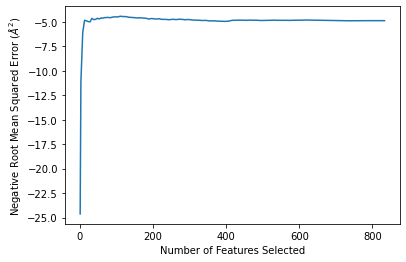

The number of features selected:  113
Selection process completed. 

Modifying descriptor matrices to use only selected descriptors...
New descriptor matrices constructed. 

Scaling descriptor matrices...
Descriptor matrices scaled. 

Building an SVR model with descriptors selected with RFE... 

     Performing grid search hyperparamter optimization...
     Grid search completed.

     Fitting SVR model...
     SVR model constructed.

     Performing k-fold cross-validation...
     Cross-validation completed.

Simplified model completed. 

Performing CCS predictions...
All predictions completed. 

-----------------------------------------------------------------------------------------------------------
MODEL VALIDATION
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
                                       CCSP 2.0: All D

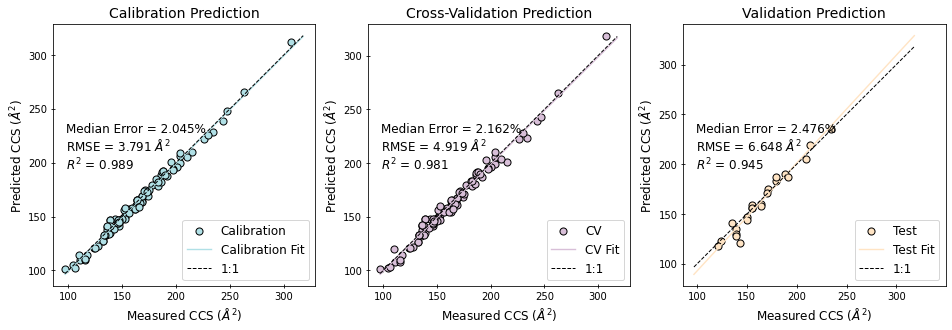

-----------------------------------------------------------------------------------------------------------
                                    CCSP 2.0: RFE Variable Selection
-----------------------------------------------------------------------------------------------------------


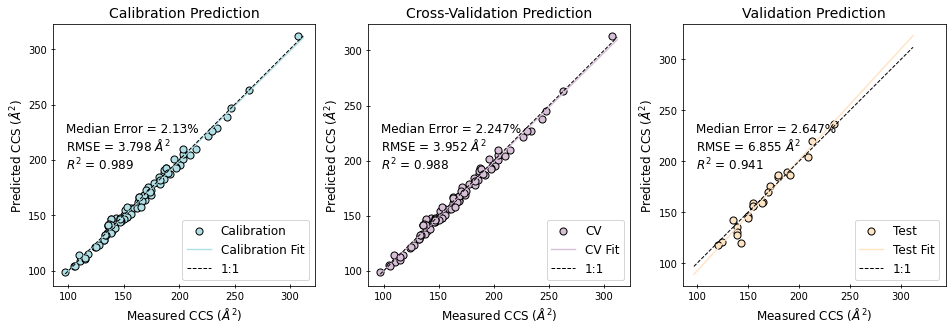

CPU times: user 13.2 s, sys: 1.72 s, total: 15 s
Wall time: 2min 26s


In [ ]:
%%time

print("-----------------------------------------------------------------------------------------------------------")
print("DATA PREPARATION")
print("-----------------------------------------------------------------------------------------------------------")

print("Waiting for user to select input files via prompt box...")
Train_Book, Test_Book, Target_Book = select_input_files()


print("Files selected. \n")

print("Checking provided training structural identifiers for invalid inputs...")
train_input_type, train_input_errors = check_inputs(Train_Book, column_title='Input')
print("Checking provided testing structural identifiers for invalid inputs...")
test_input_type, test_input_errors = check_inputs(Test_Book, column_title='Input')
print("Checking provided target structural identifiers for invalid inputs...")
target_input_type, target_input_errors = check_inputs(Target_Book, column_title='Input')


if len(train_input_errors)+len(test_input_errors)+len(target_input_errors)>0:
    print('\n', "WARNING! INVALID INPUT DETECTED. PROGRAM TERMINATED.", '\n')
    if len(train_input_errors)>0:
        print('Assuming the training input type:', train_input_type, '\n')
        print("The following training inputs returned errors:", '\n')
        for i in train_input_errors:
            print(i, '\n')
    if len(test_input_errors)>0:
        print('Assuming the testing input type:', test_input_type, '\n')
        print("The following testing inputs returned errors:", '\n')
        for i in test_input_errors:
            print(i, '\n')
    if len(target_input_errors)>0:
        print('Assuming the target input type:', target_input_type, '\n')
        print("The following target inputs returned errors:", '\n')
        for i in target_input_errors:
            print(i, '\n')
    print("Please correct these inputs and try again.")
    sys.exit()
if len(train_input_errors)+len(test_input_errors)+len(target_input_errors)==0:
    print("No input errors found. \n")

print("\n")
display("Train Workbook")
display(Train_Book)
display("Test Workbook")
display(Test_Book)
display("Target Workbook")
display(Target_Book)

##################################################################################################################
X_train, y_train, X_test, y_test, X_target = variable_assigner(Train_Book, Test_Book, Target_Book, train_input_type=train_input_type, test_input_type=test_input_type, target_input_type=target_input_type)
print("-----------------------------------------------------------------------------------------------------------")
print("MODEL TRAINING: Building an SVR Model using All Applicable Mordred Descriptors")
print("-----------------------------------------------------------------------------------------------------------")
X_train_clean, X_test_clean, X_target_clean, X_train_scaled, model, grid_results, y_train_predicted, y_train_cross_validation, y_test_predicted, y_target_predicted = initial_ccs_prediction(X_train, y_train, X_test, y_test, X_target, remove_outlier=True, threshold=1000)
print("-----------------------------------------------------------------------------------------------------------")
print("MODEL SIMPLIFICATION: Building an SVR Model using Recursive Feature Elimination")
print("-----------------------------------------------------------------------------------------------------------")
rfecv = rfe_variable_selection(X_train_scaled, y_train, grid_results)

model_rfe, grid_result_rfe, X_test_rfe, y_train_predicted_rfe, y_train_cross_validation_rfe, y_test_predicted_rfe, y_target_predicted_rfe = rfe_ccs_prediction(X_train_clean, y_train, X_test_clean, y_test, X_target_clean, rfecv)

##################################################################################################################
print("-----------------------------------------------------------------------------------------------------------")
print("MODEL VALIDATION")
print("-----------------------------------------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------------------------------------")
print("                                       CCSP 2.0: All Descriptors")
print("-----------------------------------------------------------------------------------------------------------")
summary_plot_all = summary_plot(y_train, y_test, y_train_predicted, y_train_cross_validation, y_test_predicted, labelsize = 12, legendsize = 12, titlesize = 14, textsize = 12)
print("-----------------------------------------------------------------------------------------------------------")
print("                                    CCSP 2.0: RFE Variable Selection")
print("-----------------------------------------------------------------------------------------------------------")
summary_plot_rfe = summary_plot(y_train, y_test, y_train_predicted_rfe, y_train_cross_validation_rfe, y_test_predicted_rfe, labelsize = 12, legendsize = 12, titlesize = 14, textsize = 12)

##################################################################################################################

Train_Book_Output, Test_Book_Output, Target_Book_Output = Train_Book.copy(), Test_Book.copy(), Target_Book.copy()
Train_Book_Output["Calibration CCS Prediction"] = y_train_predicted
Train_Book_Output["Cross-Validation CCS Prediction"] = y_train_cross_validation
Test_Book_Output["Validation CCS Prediction"] = y_test_predicted
Target_Book_Output["Target CCS Prediction"] = y_target_predicted
Train_Book_Output["Calibration CCS Prediction RFE VS"] = y_train_predicted_rfe
Train_Book_Output["Cross-Validation CCS Prediction RFE VS"] = y_train_cross_validation_rfe
Test_Book_Output["Validation CCS Prediction RFE VS"] = y_test_predicted_rfe
Target_Book_Output["Target CCS Prediction RFE VS"] = y_target_predicted_rfe

# This section keeps track of whether the detailed plots corresponding to the most recent predictions have been generated.
model_diagnostics_raw_boolean = False
model_diagnostics_rfe_boolean = False
timestr = time.strftime("%Y%m%d-%H%M%S")

## Prediction Export
The graphs displayed in the last steps of the prior section give us some insight into how well our model works. Assuming our target compounds are similar enough to our training set, the cross validation and external validation results will indicate how well we've predicted the CCS values for our target compounds. If you would like to save these predictions, you can run the next coding cell. It will ask if you'd like to save the data, then it will prepare an Excel file with all of the CCS predictions produced in the last section. Because Google Colaboratory will erase your work if left idle for more than 90 minutes, it is recommended that you save your work.

In [ ]:
save_predictions_boolean = save_predictions_boolean_prompt()

if save_predictions_boolean is True:
    writer = pd.ExcelWriter('/' +'CCSP-Output-' + timestr + '.xlsx', engine='xlsxwriter')
    Train_Book_Output.to_excel(writer, sheet_name='Train_Book_Output')
    Test_Book_Output.to_excel(writer, sheet_name='Test_Book_Output')
    Target_Book_Output.to_excel(writer, sheet_name='Target_Book_Output')
    writer.save()
    files.download('/' +'CCSP-Output-' + timestr + '.xlsx')

Would you like to save your CCS predictions? (YES/NO): yes
Your data is saving now.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Diagnostics Plots for Model using All 2D Descriptors
If you would like to examine the evaluation plots more closely, you can run the next cell. The first graph is the summary plot from the earlier section, while the next three plots are interactive versions of the individual subplots. The interactive plots can help quickly identify any outliers in the process. Lastly, a plot of the feature weights for each molecular descriptor is included. This cell should take less than 5 seconds to execute.

In [ ]:
%%time
summary_plot_all = summary_plot(y_train, y_test, y_train_predicted, y_train_cross_validation, y_test_predicted, labelsize = 12, legendsize = 12, titlesize = 14, textsize = 12)
prediction_plot_calibration = prediction_plot(y_train, y_train_predicted, Train_Book, hover_column=['Compound Name'], title_string="Calibration Prediction")
prediction_plot_cross_validation = prediction_plot(y_train, y_train_cross_validation, Train_Book, hover_column=['Compound Name'], title_string="Cross-Validation Prediction")
prediction_plot_validation = prediction_plot(y_test, y_test_predicted, Test_Book, hover_column=['Compound Name'], title_string="Validation Prediction")
model_diagnostic_plot = model_diagnostics_plot(X_test_clean, model)
model_diagnostics_raw_boolean = True

## Model Diagnostics Plots for Model using only Descriptors selected via Recursive Feature Elimination (RFE)

The next cell produces the same plot types as the previous cell, but visualizes the data for the simplified model using a reduced set of descriptors. The first graph is the summary plot from the earlier section, while the next three plots are interactive versions of the individual subplots. The interactive plots can help quickly identify any outliers in the process. Lastly, a plot of the feature weights for each molecular descriptor is included. Note that there are fewer descriptors in the final plot than when using the full Mordred molecular descriptor set. This cell should take less than 5 seconds to execute.

In [ ]:
%%time
summary_plot_rfe = summary_plot(y_train, y_test, y_train_predicted_rfe, y_train_cross_validation_rfe, y_test_predicted_rfe, labelsize = 12, legendsize = 12, titlesize = 14, textsize = 12)
prediction_plot_calibration_rfe = prediction_plot(y_train, y_train_predicted_rfe, Train_Book, hover_column=['Compound Name'], title_string="Calibration Prediction")
prediction_plot_cross_validation_rfe = prediction_plot(y_train, y_train_cross_validation_rfe, Train_Book, hover_column=['Compound Name'], title_string="Cross-Validation Prediction")
prediction_plot_validation_rfe = prediction_plot(y_test, y_test_predicted_rfe, Test_Book, hover_column=['Compound Name'], title_string="Validation Prediction")
model_diagnostic_plot_rfe = model_diagnostics_plot(X_test_rfe, model_rfe)

model_diagnostics_rfe_boolean = True

## Model Diagnostics Plots Export

If you would like to save the plots produced above, you can do so by running the next two coding cells. The first prepares the notebook to save .svg images, and should take less than one minute. You can move on when the output says, "Notebook prepared to save images" and the green checkmark appears by the play symbol.

In [ ]:
%%time
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
print("-----------------------------------------------------------------------------------------------------------")
print("Notebook prepared to save images.")
print("-----------------------------------------------------------------------------------------------------------")

The second cell asks if you would like to save your plots. If so, it will prepare a zip folder with all of the plots and download it to your computer. It should take less than 30 seconds to execute, and you're done!

In [ ]:
save_plots_boolean = save_plots_boolean_prompt()
if save_plots_boolean is True:
    dirpath = os.path.join('/content/' + 'CCSP-Figures-' + timestr)
    print("Creating a new directory at " + dirpath + "...")
    if os.path.exists(dirpath):
      print("   A directory with this title already exists, so it will be deleted.")
      shutil.rmtree(dirpath)
    os.mkdir(dirpath)
    print("A new directory has been created at " + dirpath + ".")
    plot_list = [summary_plot_all, summary_plot_rfe]
    plot_names = ["summary_plot_all", "summary_plot_rfe"]
    print("Saving plots to new directory...")
    print("Saving CCS Prediction Summary Plots")
    for i in range(len(plot_list)):
        save_location = '/content/' +'CCSP-Figures-' + timestr + '/' + plot_names[i] + ".svg"
        print("   Saving " + plot_names[i] + "...")
        plot_list[i].savefig(save_location)
    
    if model_diagnostics_raw_boolean == True:
        print("Saving Model Diagnostics Plots for Model using All 2D Descriptors")
        raw_plot_list = [prediction_plot_calibration, prediction_plot_cross_validation, prediction_plot_validation, model_diagnostic_plot]
        raw_plot_names = ["prediction_plot_calibration", "prediction_plot_cross_validation", "prediction_plot_validation", "model_diagnostic_plot"]
        for i in range(len(raw_plot_list)):
            save_location = '/content/' +'CCSP-Figures-' + timestr + '/' + raw_plot_names[i] + ".svg"
            print("   Saving " + raw_plot_names[i] + "...")
            raw_plot_list[i].write_image(save_location)

    if model_diagnostics_rfe_boolean == True:
        print("Saving Model Diagnostics Plots for Model using only Descriptors selected via Recursive Feature Elimination (RFE)")
        rfe_plot_list = [prediction_plot_calibration_rfe, prediction_plot_cross_validation_rfe, prediction_plot_validation_rfe, model_diagnostic_plot_rfe]
        rfe_plot_names = ["prediction_plot_calibration_rfe", "prediction_plot_cross_validation_rfe", "prediction_plot_validation_rfe", "model_diagnostic_plot_rfe"]
        for i in range(len(rfe_plot_list)):
            save_location = '/content/' +'CCSP-Figures-' + timestr + '/' + rfe_plot_names[i] + ".svg"
            print("   Saving " + rfe_plot_names[i] + "...")
            rfe_plot_list[i].write_image(save_location)



    print("All plots saved to local directory.")
    print("Creating a zipped folder will all plots...")
    !zip -r {dirpath}.zip /{dirpath}
    print("Zipped folder created.")
    print("Downloading zipped folder...")
    files.download(str(dirpath)+".zip")   
    print("Zipped folder downloaded.")

if model_diagnostics_raw_boolean == False:
  print("Warning: User did not run the cell *Model Diagnostics Plots for Model using All 2D Descriptors*, so those results were not saved.")
  
if model_diagnostics_rfe_boolean == False:
  print("Warning: User did not run the cell *Model Diagnostics Plots for Model using only Descriptors selected via Recursive Feature Elimination (RFE)*, so those results were not saved.")

## Review
Once you have reached the end of this notebook, you should have a complete record of your model's training and testing sets, and CCS predictions for your unknown target compounds. Your Excel output includes both the predictions made with all Mordred descriptors (... "CCS Prediction") and those made with the smaller descriptor set (... "CCS Prediction RFE VS"). It is up to you to decide which is more appropriate for your own data set. If you have any questions about this notebook, please email Markace Rainey (mrainey7@gatech.edu), Facundo Fernandez (fernandez@gatech.edu) or post to our Github page (https://github.com/facundof2016/CCSP2.0). You can also tag us on Twitter using #CCSP and @facundofGT.